In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11260\4088139009.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris.drop('species', axis=1).values, dtype=torch.float32)
labels = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values
labels = torch.tensor(labels, dtype=torch.long) # torch long is used for classification labels

In [3]:
class ANNClassifyClass(nn.Module):
    def __init__(self, n_units, n_layers):
        super().__init__()
        # create a dictionary to store the layers
        self.layers = nn.ModuleDict()
        self.n_layers = n_layers

        #input layer
        self.layers["input"] = nn.Linear(4, n_units)

        #hidden layer
        for layer_i in range(n_layers):
            self.layers[f"hidden_{layer_i}"] = nn.Linear(n_units, n_units)

        #output layer
        self.layers["output"] = nn.Linear(n_units, 3)

    def forward(self, x):
        x = self.layers["input"](x) # pass through input layer

        for layer_i in range(self.n_layers): # hidden layers
            x = self.layers[f"hidden_{layer_i}"](x)
            x = F.relu(x)

        x = self.layers["output"](x) # pass through output layer

        return x

In [4]:
def train_model(model, data, labels, learning_rate, epochs):

    loss_fn = nn.CrossEntropyLoss() # for multi-class classification
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):

        # forward pass
        y_pred_logits = model(data)
        loss = loss_fn(y_pred_logits, labels)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # calculate final loss, accuracy and number of parameters
    loss = loss_fn(model(data), labels).item()
    y_pred = torch.argmax(model(data), dim=1)
    accuracy = (y_pred == labels).float().mean().item()
    n_params = sum(p.numel() for p in model.parameters())
        
    return loss, accuracy, n_params

In [5]:
# Experiment with different model architectures

learning_rate = 0.01
n_units = np.arange(4, 101, 3) # units per hidden layer
n_layers = range(1, 6) # try different numbers of hidden layers
epochs = 500

accuracies = torch.zeros((len(n_units), len(n_layers)))
losses = torch.zeros((len(n_units), len(n_layers)))
total_params = torch.zeros((len(n_units), len(n_layers)))

for unit_i, n_unit in enumerate(n_units):
    for layer_i, n_layer in enumerate(n_layers):

        # create model
        model = ANNClassifyClass(n_unit, n_layer)

        # train model and store the results
        loss, accuracy, n_params = train_model(model, data, labels, learning_rate, epochs)
        accuracies[unit_i, layer_i] = accuracy
        losses[unit_i, layer_i] = loss
        total_params[unit_i, layer_i] = n_params

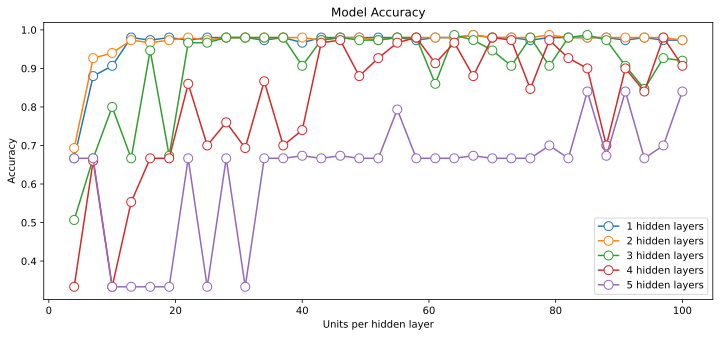

In [ ]:
# More complex models don't always perform better, but they do have more parameters.
# Since normally the more complex models require more training and more FLOPs (floating point operations), 
# we want to find the best performing model with the least parameters.
fig, ax = plt.subplots(1, figsize=(12, 5))

ax.plot(n_units, accuracies, "o-", markerfacecolor="w", markersize=9)
ax.set_title("Model Accuracy")
ax.set_xlabel("Units per hidden layer")
ax.set_ylabel("Accuracy")
ax.legend([f"{n_layer} hidden layers" for n_layer in n_layers])
plt.show()

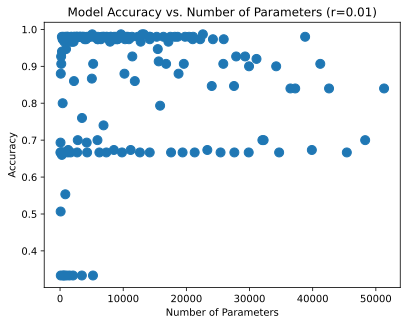

In [10]:
# we can see there is no correlation between the number of parameters and the accuracy
x = total_params.flatten()
y = accuracies.flatten()

r = np.corrcoef(x, y)[0, 1]

plt.plot(x, y, "o", markersize=9)
plt.title(f"Model Accuracy vs. Number of Parameters (r={r:.2f})")
plt.xlabel("Number of Parameters")
plt.ylabel("Accuracy")
plt.show()